In [2]:
import pandas as pd
import numpy as np
import os
import pickle

In [3]:
setSize = "large"

movies = pd.read_csv("./Datasets/"+setSize+"/movies.csv")
links = pd.read_csv("./Datasets/"+setSize+"/links.csv",usecols=['movieId','tmdbId'])
ratings = pd.read_csv("./Datasets/"+setSize+"/ratings.csv",usecols=['userId','movieId','rating'])

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
moviesWLinks = pd.merge(movies, links)
userReviews = pd.merge(ratings, moviesWLinks, how="left")
del movies, links

In [6]:
userReviews.head()

,userId,movieId,rating,title,genres,tmdbId
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0
1,1,110,4.0,Braveheart (1995),Action|Drama|War,197.0
2,1,158,4.0,Casper (1995),Adventure|Children,8839.0
3,1,260,4.5,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,11.0
4,1,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War,13.0


In [7]:
# Smaller view of DF which just has movie titles and tmdbId
titles = userReviews.groupby('title').max().reset_index()[['title','tmdbId']]
#titles = titles.sort_values('tmdbId')

In [8]:
# Aggregate the ratings by movie
# Compute the variance of ratings and number of reviews of each movie
mostViewed = userReviews.groupby('tmdbId').agg({'rating':['var'],'userId':['count']})
mostViewed = mostViewed.reset_index()
mostViewed = mostViewed.rename(columns={'userId':'nWatched','rating':'rating Variance'})
mostViewed.columns = mostViewed.columns.get_level_values(0)


In [99]:
# Get Most "controversial" movies out of top 100 Viewed Movies
# Use Variance of ratings as the proxy for this
mostViewed = mostViewed.merge(titles,how='inner')
mostViewed[mostViewed['nWatched'] > 20000].sort_values('nWatched',ascending=False).sort_values('rating Variance',ascending=False).head(25)

,tmdbId,rating Variance,nWatched,title
1605,2667.0,1.529118,24636,"Blair Witch Project, The (1999)"
3083,8467.0,1.457024,40371,Dumb & Dumber (Dumb and Dumber) (1994)
376,496.0,1.414031,20261,Borat: Cultural Learnings of America for Make ...
190,241.0,1.393441,27802,Natural Born Killers (1994)
3379,9273.0,1.371035,26642,Ace Ventura: When Nature Calls (1995)
281,345.0,1.328055,21482,Eyes Wide Shut (1999)
1209,1894.0,1.316559,28418,Star Wars: Episode II - Attack of the Clones (...
1208,1893.0,1.312820,41061,Star Wars: Episode I - The Phantom Menace (1999)
1375,2105.0,1.301872,31431,American Pie (1999)
59,95.0,1.299082,29264,Armageddon (1998)


In [10]:
#userReviews[userReviews['tmdbId'] == 77640.0]['rating'].plot.hist(bins=10)

In [11]:
userReviews['userId'].nunique()

330975

<Axes: ylabel='Frequency'>

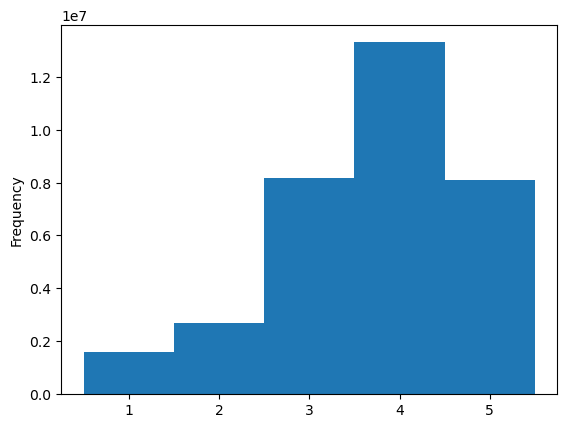

In [20]:
globalMean = userReviews['rating'].mean()
userReviews['rating'].plot.hist(bins=[0.5,1.5,2.5,3.5,4.5,5.5])

In [28]:
userReviews['filmDif'] = userReviews['rating'].apply(lambda x: x -globalMean)
filmDif = userReviews.groupby('tmdbId').agg({'filmDif':['mean']})
filmDif.columns = ['AvgFilmDif']

In [29]:
userReviews['userDif'] = userReviews['rating'].apply(lambda x: x -globalMean)
userDif = userReviews.groupby('userId').agg({'userDif':['mean']})
userDif.columns = ['AvgUserDif']

In [31]:
difDB = userReviews.join(filmDif, on='tmdbId')
difDB = difDB.join(userDif, on='userId')
difDB.head()

,userId,movieId,rating,title,genres,tmdbId,filmDif,userDif,AvgFilmDif,AvgUserDif
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,0.45746,0.45746,0.350967,0.465524
1,1,110,4.0,Braveheart (1995),Action|Drama|War,197.0,0.45746,0.45746,0.453626,0.465524
2,1,158,4.0,Casper (1995),Adventure|Children,8839.0,0.45746,0.45746,-0.653866,0.465524
3,1,260,4.5,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,11.0,0.95746,0.95746,0.549860,0.465524
4,1,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War,13.0,1.45746,1.45746,0.525649,0.465524


In [90]:
#GENERATING A BASELINE MODEL

In [36]:
from sklearn.linear_model import LinearRegression

difDB = difDB.dropna()

lr = LinearRegression()
lr.fit(difDB[['AvgUserDif','AvgFilmDif']],difDB['rating'])

LinearRegression()

In [41]:
print("Baseline Model is parameterized by:")
print("Global Mean: ", lr.intercept_)
print("Film Avg Dev from Global Mean (Weight applied): ", lr.coef_[1])
print("User Avg Dev from Global Mean (Weight applied): ", lr.coef_[0])

Baseline Model is parameterized by:
Global Mean:  3.5425328200746633
Film Avg Dev from Global Mean (Weight applied):  0.8235109339876675
User Avg Dev from Global Mean (Weight applied):  0.8597897194443196


In [92]:
# Looking at Number of Reviews for Each Movie

In [42]:
reviewCt = userReviews.groupby('tmdbId').agg({'rating':'count'})
reviewCt = reviewCt.rename({'rating':'viewCt'})
reviewCt.columns = ['viewCt']
reviewCt.columns
revCt = userReviews.join(reviewCt, on='tmdbId')

In [93]:
revCt.head()

,userId,movieId,rating,title,genres,tmdbId,filmDif,userDif,viewCt
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,0.45746,0.45746,76813.0
1,1,110,4.0,Braveheart (1995),Action|Drama|War,197.0,0.45746,0.45746,75514.0
2,1,158,4.0,Casper (1995),Adventure|Children,8839.0,0.45746,0.45746,16591.0
3,1,260,4.5,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,11.0,0.95746,0.95746,97202.0
4,1,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War,13.0,1.45746,1.45746,113581.0


In [94]:
# Experimenting with making a cutoff for min reviews required to be suggested in large DS
print("Reduction in data size",1-revCt[revCt['viewCt'] > 10000].shape[0]/revCt.shape[0])

Reduction in data size 0.4477422696190684


In [95]:
def dataReduction(viewCut):
    return 100*revCt[revCt['viewCt'] > viewCut].shape[0]/revCt.shape[0]

In [96]:
x_vals = np.arange(0,150000+1, 2500)

In [97]:
y_vals = np.array(list(map(dataReduction, x_vals)))

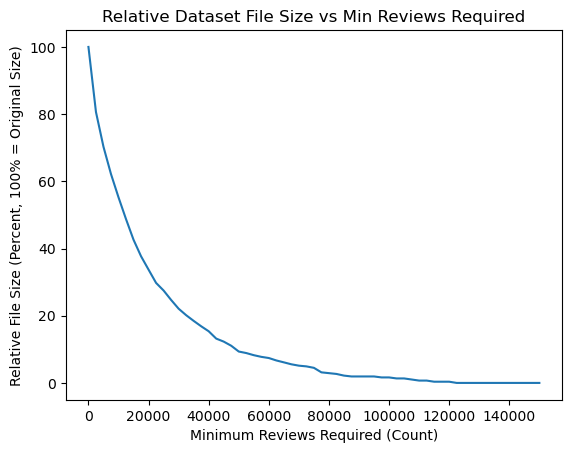

In [98]:
import matplotlib.pyplot as plt

plt.title("Relative Dataset File Size vs Min Reviews Required")
plt.xlabel("Minimum Reviews Required (Count)")
plt.ylabel("Relative File Size (Percent, 100% = Original Size)")
plt.plot(x_vals,y_vals)